This notebook contains examples of the functions in `common.py` to initialize the fields, and calculations of the theoretical peaks that will be used in the following notebooks.

In [1]:
from common import (
    initialize_fields,
    plot_field
)

In [2]:
NX = 128
NY = 128
NZ = 80

# Initializing fields

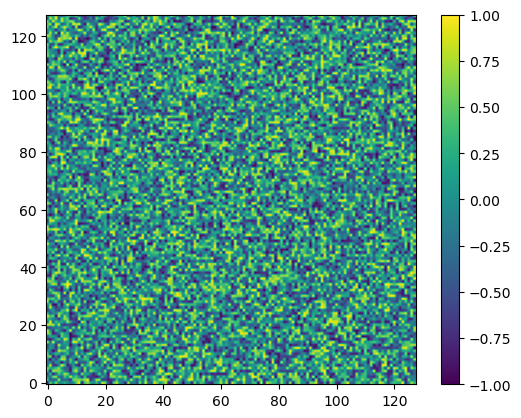

In [3]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="random")
plot_field(in_field)

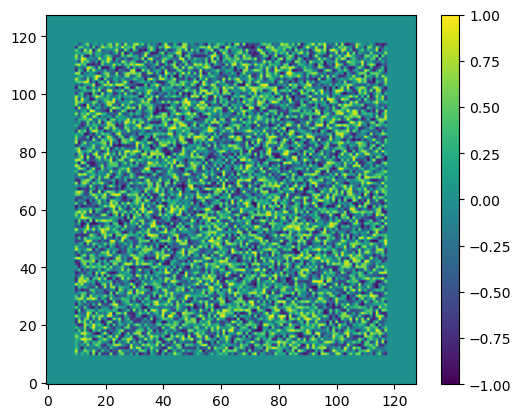

In [4]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="random", num_halo=10)
plot_field(in_field)

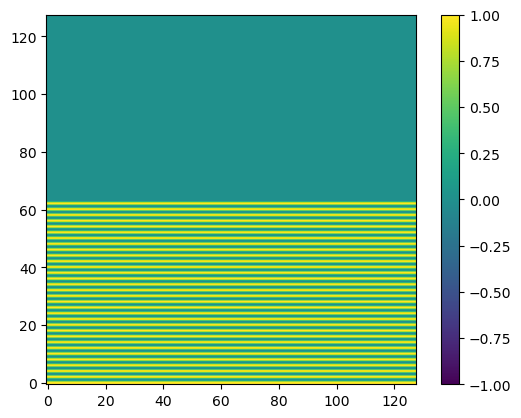

In [5]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
plot_field(in_field)

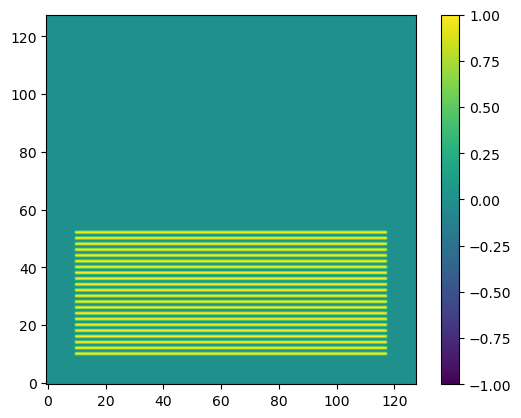

In [6]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars", num_halo=10)
plot_field(in_field)

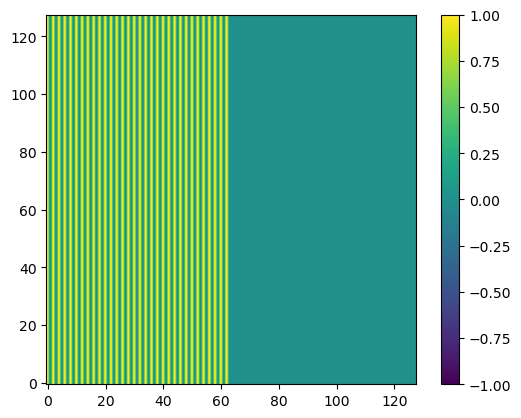

In [7]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
plot_field(in_field)

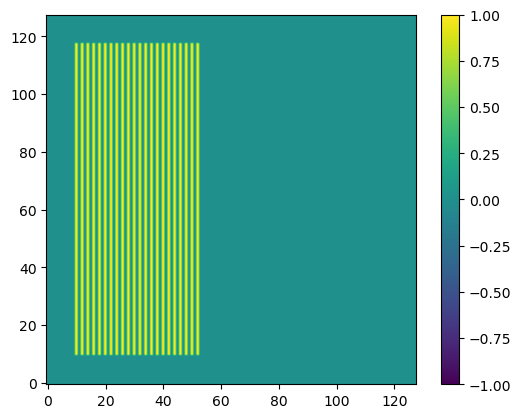

In [8]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars", num_halo=10)
plot_field(in_field)

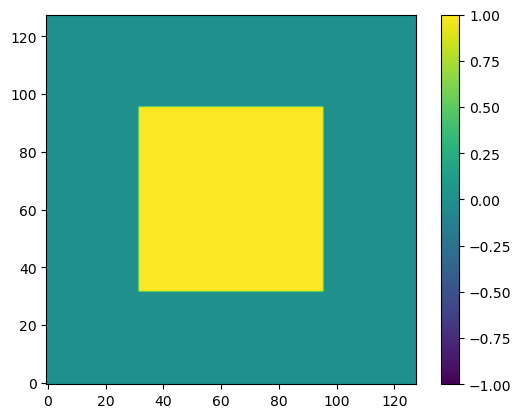

In [9]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
plot_field(in_field)

# Theoretical peaks